We find that the error for races (*workout_type = 1*) is much larger than error for other workout types. Possible fixes:
* Over sample races? As there is not many 
* Target encode races

Other feature ideas:
* Longest run of the day?
* Number of runs in a day.
* Is run named?

In [41]:
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import xgboost as xgb

from sklearn import metrics
from sklearn import preprocessing
from sklearn import impute
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack

import sys
import os 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

sys.path.append('..')
from src import config

if sys.platform == 'linux':
    path = config.LINUX_PATH
else:
    path = config.OS_PATH
os.chdir(path)

In [13]:
def run(fold):

    # read training data with folds
    df = pd.read_csv(config.STRAVA_TRAIN_KFOLD_PATH)

    # list all numeric features
    num_cols = [
        "distance",
        "moving_time",
        "total_elevation_gain",
        "max_speed",
        "average_heartrate",
        "max_heartrate",
        "suffer_score",
        "run_area",
        "average_speed_mpk",
    ]

    cat_cols = [
        "workout_type",
        "timezone",
        "manual",
        "dayofweek",
        "weekend",
        "is_uk_awake",
        "latlng_cluster",
        "city",
        "has_photo",
    ]

    ordinal_cols = ["hour", "pr_count"]

    # all cols are features except for target and kfold
    features = num_cols + cat_cols + ordinal_cols

    # fill cat column NaN values with NONE
    for col in cat_cols + ordinal_cols:
        df.loc[:, col] = df[col].astype(str).fillna("NONE")

    # training data is where kfold is not equal to fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    y_train = df_train.kudos_count.values
    # validation data is where kfold = fold
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    y_valid = df_valid.kudos_count.values

    # pipelines for model transformation
    num_pipeline = Pipeline([("imputer", impute.SimpleImputer(strategy="median"))])

    cat_pipeline = Pipeline(
        [("cat", preprocessing.OneHotEncoder(handle_unknown="ignore"))]
    )

    # transforms columns and drops columns not specified
    x_train_num = num_pipeline.fit_transform(df_train[num_cols])
    x_train_cat = cat_pipeline.fit_transform(df_train[cat_cols + ordinal_cols])
    x_valid_num = num_pipeline.transform(df_valid[num_cols])
    x_valid_cat = cat_pipeline.transform(df_valid[cat_cols + ordinal_cols])

    # check shapes are the same
    assert (
        x_train_num.shape[0] == y_train.shape[0]
    ), "training data (numeric) and label dimension are not equal"

    assert (
        x_train_cat.shape[0] == y_train.shape[0]
    ), "training data (categorical) and label dimension are not equal"

    assert (
        x_valid_num.shape[0] == y_valid.shape[0]
    ), "validation data (numeric) and label dimension are not equal"

    assert (
        x_valid_cat.shape[0] == y_valid.shape[0]
    ), "validation data (categorical) and label dimension are not equal"

    # join numeric data and categorical data
    x_train = hstack((x_train_num, x_train_cat), format="csr")
    x_valid = hstack((x_valid_num, x_valid_cat), format="csr")

    # initialize xgboost model
    model = xgb.XGBRegressor(n_jobs=-1)

    # fit model on training data
    eval_set = [(x_valid, y_valid)]
    model.fit(
        x_train,
        y_train,
        early_stopping_rounds=10,
        eval_metric="rmse",
        eval_set=eval_set,
        verbose=False,
    )
    # model.fit(x_train, y_train)

    # predict on validation data
    valid_preds = model.predict(x_valid)

    # get rmse, and mape
    rmse = metrics.mean_squared_error(y_valid, valid_preds, squared=False)
    max_error = metrics.max_error(y_valid, valid_preds)
    print(f"\nFold = {fold}, rmse = {rmse}, max error = {max_error}")

    data = [x_train, y_train, x_valid, y_valid]

    return rmse, model, data

In [14]:
scores = []
for fold_ in range(3):
    rmse, _, _ = run(fold_)
    scores.append(rmse)
print(f"\nAverage rmse = {sum(scores) / len(scores)}")


Fold = 0, rmse = 10.378402261784807, max error = 51.87763214111328

Fold = 1, rmse = 9.724660758527556, max error = 54.94829177856445

Fold = 2, rmse = 11.12238115799922, max error = 86.98245239257812

Average rmse = 10.408481392770527


In [21]:
_, model, data = run(1)
x_train, y_train, x_valid, y_valid = data
y_pred = model.predict(x_valid)


Fold = 1, rmse = 9.724660758527556, max error = 54.94829177856445


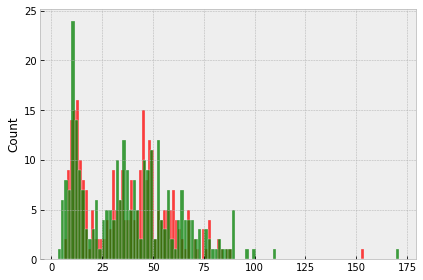

In [33]:
# plt.figure(figsize=(9, 8))
fig, ax = plt.subplots()
plt.rcParams["figure.autolayout"] = True
sns.histplot(y_pred, color='r', bins=100, ax=ax);
sns.histplot(y_valid, color='g', bins=100, ax=ax);
plt.show()

In [51]:
df = pd.read_csv(config.STRAVA_TRAIN_KFOLD_PATH)
num_cols = [
    "distance",
    "moving_time",
    "average_speed_mpk",
]

cat_cols = [
  "workout_type",
  "timezone",
  "manual",
  "weekend",
  "is_uk_awake",
  "has_photo",
]
ordinal_cols = ["pr_count"]

# all cols are features except for target and kfold
features = ['name'] + num_cols + cat_cols + ordinal_cols

df_valid = df[df.kfold == 1].reset_index(drop=True)
y_valid = df_valid.kudos_count.values
x_valid = df_valid[features]
x_valid.loc[:, "target"] = y_valid
x_valid.loc[:, "target_pred"] = y_pred
x_valid.loc[:, "error"] = np.sqrt((x_valid.target - x_valid.target_pred)**2)
x_valid.head()

,name,distance,moving_time,average_speed_mpk,workout_type,timezone,manual,weekend,is_uk_awake,has_photo,pr_count,target,target_pred,error
0,BUCS XC - 12th,10.1666,33.383333,3.283294,1.0,Europe/London,False,1,1,1,0,171,153.939957,17.060043
1,Scottish virtual road relays - 14:26,5.0163,14.483333,2.887387,1.0,Europe/London,False,1,1,0,1,109,87.462585,21.537415
2,Inform,8.6285,38.883333,4.506760,0.0,America/Boise,False,0,1,0,0,34,34.068058,0.068058
3,‘Warm’ springs golf course,7.1609,32.833333,4.584869,0.0,America/Boise,False,0,1,0,0,20,27.573109,7.573109
4,Timed to perfection,5.2925,22.666667,4.282117,0.0,Europe/London,False,0,1,0,0,28,28.524858,0.524858


In [56]:
# top 10 errors 
x_valid.sort_values(by = 'error', ascending=False).head(10)

,name,distance,moving_time,average_speed_mpk,workout_type,timezone,manual,weekend,is_uk_awake,has_photo,pr_count,target,target_pred,error
30,Morning Run,21.0937,90.000000,4.266769,0.0,Europe/London,False,0,1,0,3,6,60.948292,54.948292
227,1500m tt - 3:57,1.5000,3.950000,2.633275,1.0,Europe/London,True,0,1,0,0,100,53.973282,46.026718
136,Feel like a runner again,16.1170,67.400000,4.182183,0.0,America/Boise,False,0,1,0,0,87,47.369640,39.630360
61,"No water in canal, so ran in the actually cana...",7.0082,32.333333,4.614064,0.0,America/Boise,False,0,0,0,0,57,21.857183,35.142817
273,Reborn,14.0190,64.800000,4.621742,0.0,America/Boise,False,0,1,0,0,90,59.283298,30.716702
270,Cold,9.3798,30.033333,3.201921,3.0,Europe/London,False,0,1,1,1,77,49.372093,27.627907
204,Inaudible noises,6.4552,29.500000,4.569783,0.0,America/Boise,False,0,0,0,0,45,23.383360,21.616640
1,Scottish virtual road relays - 14:26,5.0163,14.483333,2.887387,1.0,Europe/London,False,1,1,0,1,109,87.462585,21.537415
137,Ready to dance,2.0516,10.250000,4.995803,0.0,Europe/London,False,0,1,0,1,36,15.379934,20.620066
262,18 x 1 min hills,12.8902,49.100000,3.809371,3.0,America/Boise,False,0,1,0,1,71,50.385086,20.614914


In [64]:
# error by workout_type
mean_per_workout = x_valid.groupby("workout_type").mean().reset_index()
mean_per_workout[['workout_type','target', 'target_pred', 'error']]

,workout_type,target,target_pred,error
0,0.0,34.059091,33.276520,6.036243
1,1.0,126.666667,98.458611,28.208059
2,2.0,75.909091,76.252136,10.464377
3,3.0,58.655172,54.698689,8.530135


In [65]:
# error by timezone
mean_per_workout = x_valid.groupby("timezone").mean().reset_index()
mean_per_workout[['timezone','target', 'target_pred', 'error']]

,timezone,target,target_pred,error
0,America/Boise,38.944954,37.947948,6.954940
1,America/Los_Angeles,23.000000,26.371054,4.761965
2,America/New_York,36.933333,36.392189,5.682637
3,Europe/London,38.760274,37.221565,6.569736
4,Europe/Madrid,62.000000,57.228077,4.771923
5,Europe/Zurich,22.000000,14.534758,7.465242
